In [ ]:
# @title Install Requirements
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [12]:
# @title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple, deque
import itertools

In [13]:
# @title DQN
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.

        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """

        super(DQN, self).__init__()

        if len(obs_shape) == 3:
            obs_shape = (1, *obs_shape)

        self.conv1 = nn.Conv2d(in_channels=obs_shape[-1], out_channels=16, kernel_size=5, stride=1, padding='same')
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.relu2 = nn.ReLU()

        self.fc1 = nn.Linear(in_features=32 * obs_shape[1] * obs_shape[2], out_features=128)
        self.relu4 = nn.ReLU()

        self.output = nn.Linear(in_features=128, out_features=num_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.relu4(self.fc1(x))
        x = self.output(x)
        return x


In [14]:
# @title Policy
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon. Taken from last exercise with changes.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        return Q(obs).argmax().detach().numpy()

    return policy_fn

def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    epsilon = eps_start - (eps_start - eps_end) * (current_timestep / duration)
    return max(epsilon, eps_end)

In [15]:
# @title Replay Buffer
from dataclasses import replace
class ReplayBuffer:
    def __init__(self, max_size: int, n_step: int, gamma: float):
        """
        Create a multi-step replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        :param n_step: Number of steps for multi-step returns.
        :param gamma: Discount factor for calculating multi-step returns.
        """
        self.replay_buffer = deque(maxlen=max_size)
        self.max_size = max_size

        self.n_step = n_step
        self.gamma = gamma


    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.replay_buffer)


    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the n-step buffer and stores the multi-step return in the replay buffer when enough steps are collected.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        self.replay_buffer.append((obs, action, reward, next_obs, terminated))


    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        indices = random.choices(range(len(self.replay_buffer)), k=batch_size)

        obs_batch = []
        action_batch = []
        next_obs_batch = []
        reward_batch = []
        terminated_batch = []
        batch = []

        for i in indices:
            sum_reward = 0
            states_look_ahead = self.replay_buffer[i][3]
            done_look_ahead = self.replay_buffer[i][4]

            # N-step look ahead loop to compute the reward and pick the new 'next_state' (of the n-th state)
            for n in range(self.n_step):
                if len(self.replay_buffer) > i+n:
                    # compute the n-th reward
                    sum_reward += (self.gamma**n) * self.replay_buffer[i+n][2]
                    if self.replay_buffer[i+n][4]: # next obs is terminated
                        states_look_ahead = self.replay_buffer[i+n][3]
                        done_look_ahead = torch.tensor(True)
                        break
                    else:
                        states_look_ahead = self.replay_buffer[i+n][3]
                        done_look_ahead = torch.tensor(False)

            batch.append((self.replay_buffer[i][0], self.replay_buffer[i][1], sum_reward, states_look_ahead, done_look_ahead))

        obs_batch = torch.stack([t[0] for t in batch])
        action_batch = torch.stack([t[1] for t in batch])
        reward_batch = torch.stack([t[2] for t in batch])
        next_obs_batch = torch.stack([t[3] for t in batch])
        terminated_batch = torch.stack([t[4] for t in batch])

        return (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch)

In [16]:
# @title Update DQN
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    optimizer.zero_grad()
    with torch.no_grad():
        next_q_value = q_target(next_obs).max(dim=1)[0]
        td_target = rew + (gamma * next_q_value)

    current_q_value = q(obs).gather(1, act.unsqueeze(1))

    loss = nn.MSELoss()(current_q_value, td_target.unsqueeze(1))

    loss.backward()
    optimizer.step()


In [17]:
# @title DQN Agent
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class DQNAgent:
    def __init__(self,
            env,
            gamma=0.9,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=1_000,
            update_freq=100,
            maxlen=100_000,
            n_step=5,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.n_step = n_step

        # Initialize the Replay Buffer
        self.replay_buffer = ReplayBuffer(max_size=maxlen, n_step=self.n_step, gamma=gamma)

        # Initialize the Deep Q-Network
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # Initialize the second Q-Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)

        params = copy.deepcopy(self.q.state_dict())
        self.q_target.load_state_dict(params)

        # Create an ADAM optimizer for the Q-network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes)
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % self.update_freq == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():

                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.replay_buffer.store(torch.tensor(obs), torch.tensor(action), torch.tensor(reward), torch.tensor(next_obs), torch.tensor(terminated))

                # if self.replay_buffer.__len__() >= 1:
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.replay_buffer.sample(self.batch_size)

                update_dqn(
                            self.q,
                            self.q_target,
                            self.optimizer,
                            self.gamma,
                            obs_batch.float(),
                            act_batch,
                            rew_batch.float(),
                            next_obs_batch.float(),
                            tm_batch)

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())

                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [29]:
# @title Train

# Choose your environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

LR = 0.001
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 10_000
UPDATE_FREQ = 100
EPS_START = 0.9
EPS_END = 0.01
SCHEDULE_DURATION = 13_000
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.8
N_Step = 5

# Train DQN
agent = DQNAgent(
                env,
                gamma=DISCOUNT_FACTOR,
                lr=LR,
                batch_size=BATCH_SIZE,
                eps_start=EPS_START,
                eps_end=EPS_END,
                schedule_duration=SCHEDULE_DURATION,
                update_freq=UPDATE_FREQ,
                maxlen=REPLAY_BUFFER_SIZE,
                n_step=N_Step
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)

Episode 100 of 1000  Time Step: 1126  Epsilon: 0.823
Episode 200 of 1000  Time Step: 2352  Epsilon: 0.739
Episode 300 of 1000  Time Step: 3524  Epsilon: 0.659
Episode 400 of 1000  Time Step: 4804  Epsilon: 0.571
Episode 500 of 1000  Time Step: 6274  Epsilon: 0.471
Episode 600 of 1000  Time Step: 8000  Epsilon: 0.352
Episode 700 of 1000  Time Step: 10200  Epsilon: 0.202
Episode 800 of 1000  Time Step: 13214  Epsilon: 0.010
Episode 900 of 1000  Time Step: 16490  Epsilon: 0.010
Episode 1000 of 1000  Time Step: 19728  Epsilon: 0.010


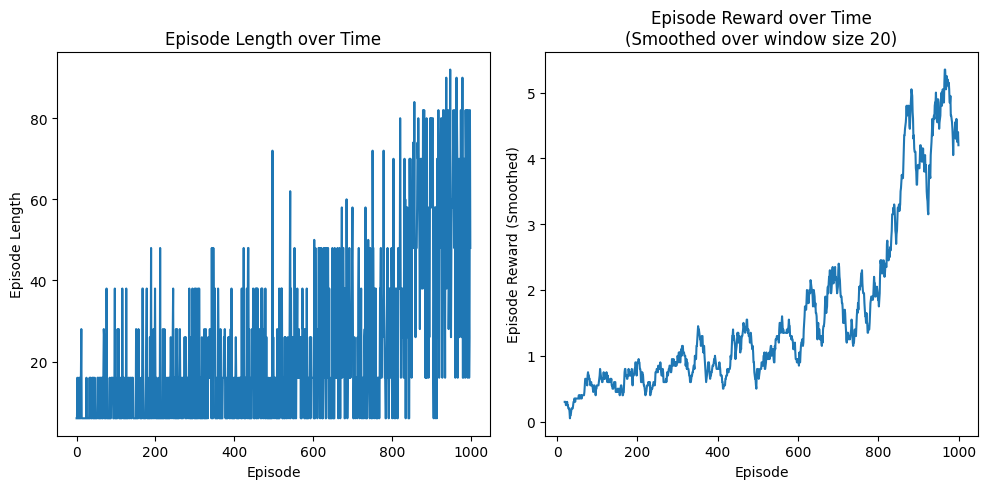

In [26]:
# @title Plots

smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


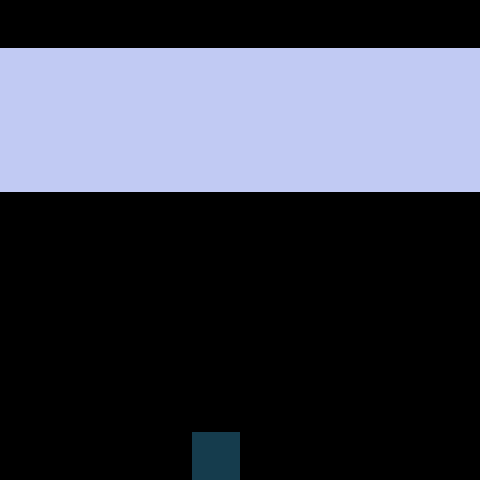

In [27]:
# @title The Final Policy

from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1000_000_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for i in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            print(i)
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")